In [2]:
import sys
sys.path.insert(0, '../..')  # Füge das übergeordnete Verzeichnis zum Python-Pfad hinzu
from utils_functions import to_float_array, df_d0, dataframe1

In [3]:
# Versuche, die erste Sheet aus einer .ods Datei im Workspace einzulesen
import glob
import os
import pandas as pd
from IPython.display import display
import numpy as np

# Suche rekursiv nach .ods Dateien im Workspace-Ordner
ods_files = glob.glob('/workspaces/EWT/**/*.ods', recursive=True)
if len(ods_files) == 0:
    ods_files = glob.glob('**/*.ods', recursive=True)

if len(ods_files) == 0:
    print('Keine .ods Datei im Workspace gefunden. Lege bitte die Datei `EWT4.ods` in das Projekt oder passe den Pfad an.')
    df_ods = None
else:
    ods_path = ods_files[0]
    print(f'Gefundene .ods Datei: {ods_path} — versuche, erstes Sheet einzulesen...')
    df_ods = None
    # 1) Versuch: pandas mit odf engine
    try:
        df_ods = pd.read_excel(ods_path, engine='odf', sheet_name=0, skiprows=36)
        print('Gelesen mit pandas (engine=odf).')
    except Exception as e:
        print('pandas.read_excel(engine="odf") failed:', e)
        print('Stelle sicher, dass das Paket `odfpy` installiert ist (`pip install odfpy`).')
        # 2) Fallback: pyexcel_ods3
        try:
            import pyexcel_ods3
            data = pyexcel_ods3.get_data(ods_path)
            first_sheet = list(data.keys())[0]
            df_ods = pd.DataFrame(data[first_sheet])
            print('Gelesen mit pyexcel_ods3 (Fallback).')
        except Exception as e2:
            print('Fallback mit pyexcel_ods3 ebenfalls fehlgeschlagen:', e2)
            df_ods = None

if df_ods is not None:
    print('\nEingelesenes DataFrame:')
    print('  shape =', df_ods.shape)
    display(df_ods.head())
else:
    print('\nKein DataFrame eingelesen. Installiere `odfpy` oder `pyexcel_ods3` und versuche es erneut, oder gib mir den Pfad zur Datei.')
    print('Install: pip install odfpy  # oder pip install pyexcel-ods3')
print(ods_files)


Gefundene .ods Datei: /workspaces/EWT/1mM Lactat 2. Messung.ods — versuche, erstes Sheet einzulesen...
Gelesen mit pandas (engine=odf).

Eingelesenes DataFrame:
  shape = (16, 122)


,Zyklus Nr.,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,Zeit [s],0,4,8,12,16,20,24,28,32,...,444,448,452,456,460,464,468,472,476,480
1,Temp. [°C],--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
2,B1,15843,16121,15994,15915,16005,15949,15839,15880,15829,...,15994,16017,15844,15743,15720,15791,15715,15737,15664,15561
3,B2,43230,43479,42759,42159,42094,41388,41435,41316,41257,...,26779,26732,26471,26164,26142,25936,25815,25733,25628,25277
4,B3,22949,22902,22420,22091,21946,21462,21452,21425,21157,...,16292,16254,16109,15930,15917,15937,15959,15967,15979,15769


['/workspaces/EWT/1mM Lactat 2. Messung.ods', '/workspaces/EWT/EWT4/DATA/MCT1_Influx verschiedene_ ilaccos.ods', '/workspaces/EWT/EWT4/DATA/ETW4.ods', '/workspaces/EWT/EWT2/data/1 mM Lactat_1_20 Verdünnung_1. Messung.ods', '/workspaces/EWT/EWT2/data/1 mM Lactat_1_20 Verdünnung_3. Messung.ods', '/workspaces/EWT/EWT2/data/1 mM Lactat_1_20 Verdünnung_2. Messung.ods']


In [ ]:
# Funktion zur Verarbeitung der Influx-Daten
def Influx_data(df1, x, y, z, w):
    """
    Erstellt einen DataFrame mit Mittelwerten und Standardabweichungen
    aus einem CSV-DataFrame und vier Zeilenindizes.
    
    Parameter:
    - df1: Eingabe-DataFrame (aus CSV)
    - x, y, z, w: Zeilenindizes für Zeit und die drei Messungen
    
    Rückgabe:
    - DataFrame mit Spalten: Time, 1.Messung, 2.Messung, 3.Messung, 
      Mittelwerte, Standardabweichung
    """
    df1 = df1.replace('OVER', np.nan)
    mM_10 = pd.DataFrame()
    mM_1= pd.DataFrame()
    mM_0_1 = pd.DataFrame()
    results = pd.DataFrame()
    results["Time"] = to_float_array(np.array(df1.iloc[x])[1:])
    mM_10["Time"] = to_float_array(np.array(df1.iloc[x])[1:])
    mM_1["Time"] = to_float_array(np.array(df1.iloc[x])[1:])
    mM_0_1["Time"] = to_float_array(np.array(df1.iloc[x])[1:])
    #10mM    
    mM_10["1.Messung"] = df_d0(to_float_array(np.array(df1.iloc[y])[1:]))
    mM_10["2.Messung"] = df_d0(to_float_array(np.array(df1.iloc[z])[1:]))
    mM_10["3.Messung"] = df_d0(to_float_array(np.array(df1.iloc[w])[1:]))
    
    # Berechne Mittelwert über die ersten drei Messung-Spalten
    mittelwerte1 = mM_10[["1.Messung", "2.Messung", "3.Messung"]].mean(axis=1).tolist()
    results["10 mM Mittelwerte"] = mittelwerte1
    
    # Berechne Standardabweichung
    standardabweichung1 = mM_10[["1.Messung", "2.Messung", "3.Messung"]].std(axis=1).tolist()
    results["10 mM Standardabweichung"] = standardabweichung1
    
    #1mM
       
    mM_1["1.Messung"] = df_d0(to_float_array(np.array(df1.iloc[y+3])[1:]))
    mM_1["2.Messung"] = df_d0(to_float_array(np.array(df1.iloc[z+3])[1:]))
    mM_1["3.Messung"] = df_d0(to_float_array(np.array(df1.iloc[w+3])[1:]))
    
    # Berechne Mittelwert über die ersten drei Messung-Spalten
    mittelwerte2 = mM_1[["1.Messung", "2.Messung", "3.Messung"]].mean(axis=1).tolist()
    results["1 mM Mittelwerte"] = mittelwerte2
    
    # Berechne Standardabweichung
    standardabweichung2 = mM_1[["1.Messung", "2.Messung", "3.Messung"]].std(axis=1).tolist()
    results["1 mM Standardabweichung"] = standardabweichung2
    
    #0,1 mM
    #10mM    
    mM_0_1["1.Messung"] = df_d0(to_float_array(np.array(df1.iloc[y+6])[1:]))
    mM_0_1["2.Messung"] = df_d0(to_float_array(np.array(df1.iloc[z+6])[1:]))
    mM_0_1["3.Messung"] = df_d0(to_float_array(np.array(df1.iloc[w+6])[1:]))
    
    # Berechne Mittelwert über die ersten drei Messung-Spalten
    mittelwerte3 = mM_0_1[["1.Messung", "2.Messung", "3.Messung"]].mean(axis=1).tolist()
    results["0,1 mM Mittelwerte"] = mittelwerte3
    
    # Berechne Standardabweichung
    standardabweichung3 = mM_0_1[["1.Messung", "2.Messung", "3.Messung"]].std(axis=1).tolist()
    results["0,1 mM Standardabweichung"] = standardabweichung3
    
    
    # Stelle sicher, dass 'Time' numeric ist
    
    merged = mM_10.merge(mM_1, on='Time', how='outer', suffixes=('_10','_1'))
    merged = merged.merge(mM_0_1, on='Time', how='outer')
    merged = merged.sort_values('Time').reset_index(drop=True)
    return results, merged

In [ ]:
# Daten einlesen in Dataframes
data_path = '/workspaces/EWT/EWT4/DATA/ETW4.ods'
df_I_MCT1_ilacco1_0 = pd.read_excel(data_path, engine='odf', sheet_name="Sheet3", skiprows=36)
df_I_MCT1_ilacco1_0_50µM_CCCP = pd.read_excel(data_path, engine='odf', sheet_name="Sheet4", skiprows=36)
df_I_MCT1_ilacco1_1= pd.read_excel(data_path, engine='odf', sheet_name="Sheet5", skiprows=36)
df_I_MCT1_ilacco1_2= pd.read_excel(data_path, engine='odf', sheet_name="Sheet6", skiprows=36)


In [20]:
# Daten verarbeiten
I_MCT1_ilacco1_0, M1 = Influx_data(df_I_MCT1_ilacco1_0,3,5,6,7)
I_MCT1_ilacco1_0_50μM_CCCP, M2 = Influx_data(df_I_MCT1_ilacco1_0_50μM_CCCP,3,5,6,7)
I_MCT1_ilacco1_1,M3 = Influx_data(df_I_MCT1_ilacco1_1,3,5,6,7)
I_MCT1_ilacco1_2, M4 = Influx_data(df_I_MCT1_ilacco1_2,3,5,6,7)



Saved plot: ../figueres/I_MCT1_ilacco1_0_plot.png


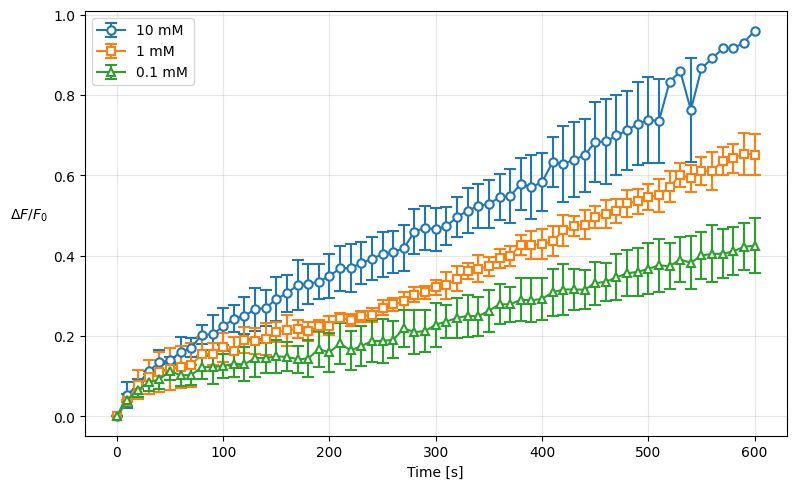

Saved plot: ../figueres/I_MCT1_ilacco1_0_50μM_CCCP_plot.png


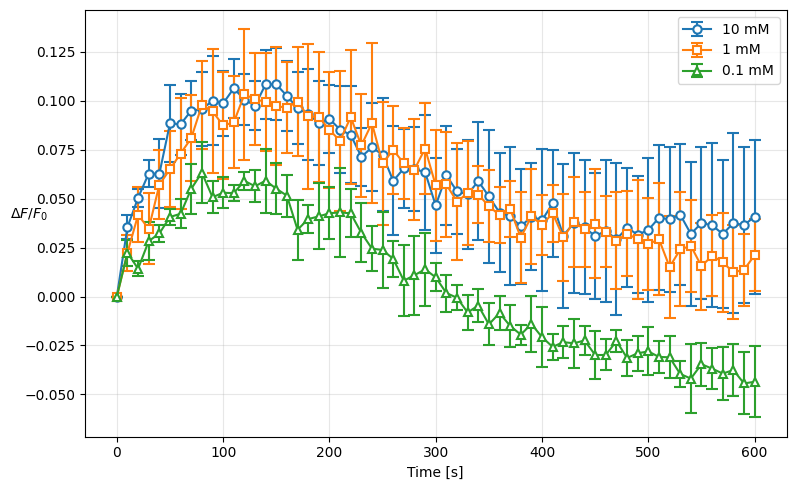

Saved plot: ../figueres/I_MCT1_ilacco1_1_plot.png


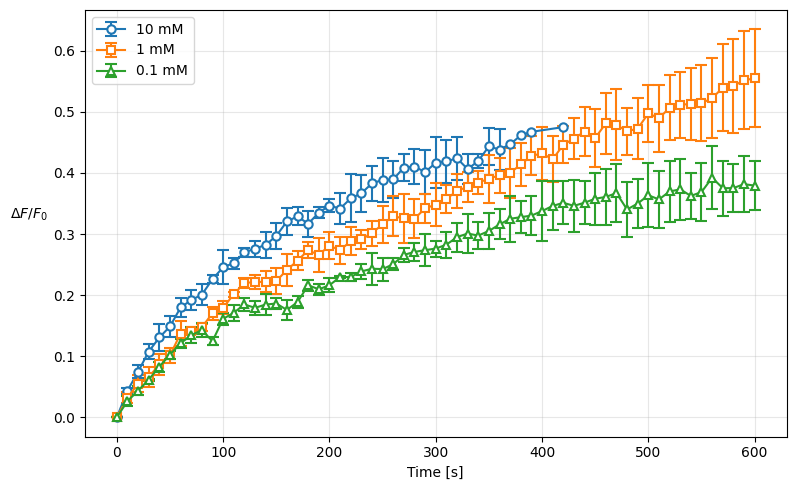

Saved plot: ../figueres/I_MCT1_ilacco1_2_plot.png


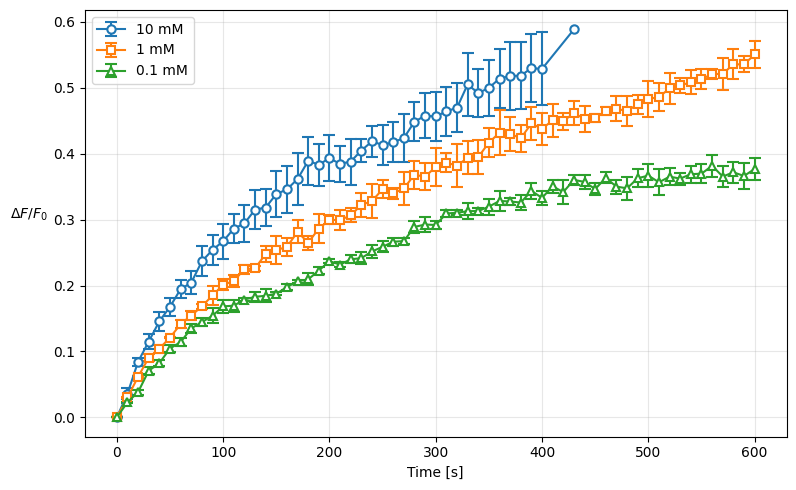

In [14]:
# Erzeuge Plots für die DataFrames, die in der vorherigen Zelle erzeugt wurden.
# Für jeden DataFrame wird ein Plot erstellt, der 10 mM, 1 mM und 0.1 mM (Mittelwerte)
# gegen Time darstellt und die jeweilige Standardabweichung als Fehlerbalken zeigt.

import os
import matplotlib.pyplot as plt

frames = [
    ('I_MCT1_ilacco1_0', globals().get('I_MCT1_ilacco1_0', None)),
    ('I_MCT1_ilacco1_0_50μM_CCCP', globals().get('I_MCT1_ilacco1_0_50μM_CCCP', None)),
    ('I_MCT1_ilacco1_1', globals().get('I_MCT1_ilacco1_1', None)),
    ('I_MCT1_ilacco1_2', globals().get('I_MCT1_ilacco1_2', None)),
]

concs = ['10 mM', '1 mM', '0.1 mM']

# Mappings für mögliche Spaltenname-Varianten
mean_patterns = {
    '10 mM': ['10 mM mean', '10 mM Mittelwerte', '10 mM Mittelwerte', '10 mM Mittelwerte', '10 mM Mittelwerte', '10 mM Mittelwerte', '10,0 mM Mittelwerte', '10mM mean'],
    '1 mM':  ['1 mM mean', '1 mM Mittelwerte', '1 mM Mittelwerte', '1mM mean'],
    '0.1 mM': ['0.1 mM mean', '0,1 mM Mittelwerte', '0,1 mM Mittelwerte', '0.1 mM Mittelwerte', '0,1 mM mean']
}
std_patterns = {
    '10 mM': ['10 mM std', '10 mM Standardabweichung', '10 mM Standardabweichung'],
    '1 mM':  ['1 mM std', '1 mM Standardabweichung', '1 mM Standardabweichung'],
    '0.1 mM': ['0.1 mM std', '0,1 mM Standardabweichung', '0.1 mM Standardabweichung']
}

os.makedirs(os.path.join('..', 'figueres'), exist_ok=True)

def find_column(df, patterns):
    if df is None:
        return None
    for p in patterns:
        if p in df.columns:
            return p
    # Fallback: suche nach Spalte, die token enthält
    for col in df.columns:
        low = col.lower()
        for p in patterns:
            if p.split()[0].lower().replace(',', '.') in low and ('mean' in p.lower() or 'mittel' in p.lower() or 'std' in p.lower() or 'standard' in p.lower()):
                return col
    return None

for name, df in frames:
    if df is None:
        print(f"Variable {name} nicht gefunden — überspringe.")
        continue
    # Versuche Time-Spalte
    time_col = None
    for candidate in ['Time', 'time', 'Zeit', 'Zeit [s]']:
        if candidate in df.columns:
            time_col = candidate
            break
    if time_col is None:
        # eventuell erste Spalte
        time_col = df.columns[0]

    plt.figure(figsize=(8,5))
    plotted_any = False

    # Verschiedene Marker für jede Konzentration (zusätzlich zur Farbe)
    markers = {'10 mM': 'o', '1 mM': 's', '0.1 mM': '^'}
    
    for conc in concs:
        mean_col = find_column(df, mean_patterns.get(conc, []))
        std_col = find_column(df, std_patterns.get(conc, []))

        # Zusätzliche Versuche: deutsche Namensschema
        if mean_col is None:
            # suche nach Spalten, die die Konzentration und 'mittel'/'mittelwerte' enthalten
            for col in df.columns:
                low = col.lower()
                if conc.split()[0] in low and ('mittel' in low or 'mean' in low):
                    mean_col = col
                    break
        if std_col is None:
            for col in df.columns:
                low = col.lower()
                if conc.split()[0] in low and ('std' in low or 'standard' in low or 'abweich' in low):
                    std_col = col
                    break

        if mean_col is None:
            print(f"Für {name}: Mean-Spalte für {conc} nicht gefunden — überspringe {conc}.")
            continue

        times = pd.to_numeric(df[time_col], errors='coerce')
        means = pd.to_numeric(df[mean_col], errors='coerce')
        if std_col is not None:
            stds = pd.to_numeric(df[std_col], errors='coerce')
        else:
            stds = np.zeros_like(means)

        mask = (~times.isna()) & (~means.isna())
        if mask.sum() == 0:
            print(f"Für {name}/{conc}: Keine gültigen Datenpunkte.")
            continue

        marker = markers.get(conc, 'o')
        # Label kombiniert Dateinamen und Konzentration
        label = conc
        plt.errorbar(times[mask], means[mask], yerr=stds[mask], 
                    marker=marker, linestyle='-', label=label, capsize=4, 
                    markerfacecolor='white', markeredgewidth=1.5, markersize=6)
        plotted_any = True

    if not plotted_any:
        print(f"Keine Daten zum Plotten in {name} gefunden.")
        plt.close()
        continue

    plt.xlabel('Time [s]')
    plt.ylabel(r'$\Delta F/F_0$', rotation=0, labelpad=12)
    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.08, 0.5)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    outpath = os.path.join('..', 'figueres', f'{name}_plot.png')
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    print(f'Saved plot: {outpath}')
    plt.show()


In [1]:
# Kombinierte Abbildung: Alle DataFrames in einer 2x2 Subplot-Anordnung
import os
import matplotlib.pyplot as plt

frames = [
    ('I_MCT1_ilacco1_0', globals().get('I_MCT1_ilacco1_0', None)),
    ('I_MCT1_ilacco1_0_50μM_CCCP', globals().get('I_MCT1_ilacco1_0_50μM_CCCP', None)),
    ('I_MCT1_ilacco1_1', globals().get('I_MCT1_ilacco1_1', None)),
    ('I_MCT1_ilacco1_2', globals().get('I_MCT1_ilacco1_2', None)),
]

concs = ['10 mM', '1 mM', '0.1 mM']

# Mappings für mögliche Spaltenname-Varianten
mean_patterns = {
    '10 mM': ['10 mM mean', '10 mM Mittelwerte', '10 mM Mittelwerte', '10 mM Mittelwerte', '10 mM Mittelwerte', '10 mM Mittelwerte', '10,0 mM Mittelwerte', '10mM mean'],
    '1 mM':  ['1 mM mean', '1 mM Mittelwerte', '1 mM Mittelwerte', '1mM mean'],
    '0.1 mM': ['0.1 mM mean', '0,1 mM Mittelwerte', '0,1 mM Mittelwerte', '0.1 mM Mittelwerte', '0,1 mM mean']
}
std_patterns = {
    '10 mM': ['10 mM std', '10 mM Standardabweichung', '10 mM Standardabweichung'],
    '1 mM':  ['1 mM std', '1 mM Standardabweichung', '1 mM Standardabweichung'],
    '0.1 mM': ['0.1 mM std', '0,1 mM Standardabweichung', '0.1 mM Standardabweichung']
}

os.makedirs(os.path.join('..', 'figueres'), exist_ok=True)

def find_column(df, patterns):
    if df is None:
        return None
    for p in patterns:
        if p in df.columns:
            return p
    # Fallback: suche nach Spalte, die token enthält
    for col in df.columns:
        low = col.lower()
        for p in patterns:
            if p.split()[0].lower().replace(',', '.') in low and ('mean' in p.lower() or 'mittel' in p.lower() or 'std' in p.lower() or 'standard' in p.lower()):
                return col
    return None

# Erstelle 2x2 Subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Verschiedene Marker für jede Konzentration (zusätzlich zur Farbe)
markers = {'10 mM': 'o', '1 mM': 's', '0.1 mM': '^'}

for plot_idx, (name, df) in enumerate(frames):
all_times = []
all_values = []

for plot_idx, (name, df) in enumerate(frames):
    ax = axes[plot_idx]
    
    if df is None:
        ax.text(0.5, 0.5, f"Variable {name} nicht gefunden", 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(name)
        continue
    
    # Versuche Time-Spalte
    time_col = None
    for candidate in ['Time', 'time', 'Zeit', 'Zeit [s]']:
        if candidate in df.columns:
            time_col = candidate
            break
    if time_col is None:
        time_col = df.columns[0]

    plotted_any = False
    
    for conc in concs:
        mean_col = find_column(df, mean_patterns.get(conc, []))
        std_col = find_column(df, std_patterns.get(conc, []))

        # Zusätzliche Versuche: deutsche Namensschema
        if mean_col is None:
            for col in df.columns:
                low = col.lower()
                if conc.split()[0] in low and ('mittel' in low or 'mean' in low):
                    mean_col = col
                    break
        if std_col is None:
            for col in df.columns:
                low = col.lower()
                if conc.split()[0] in low and ('std' in low or 'standard' in low or 'abweich' in low):
                    std_col = col
                    break

        if mean_col is None:
            continue

        times = pd.to_numeric(df[time_col], errors='coerce')
        means = pd.to_numeric(df[mean_col], errors='coerce')
        if std_col is not None:
            stds = pd.to_numeric(df[std_col], errors='coerce')
        else:
            stds = np.zeros_like(means)

        mask = (~times.isna()) & (~means.isna())
        if mask.sum() == 0:
            continue

        # Sammle Werte für Skalierung
        all_times.extend(times[mask].values)
        all_values.extend(means[mask].values)

        marker = markers.get(conc, 'o')
        ax.errorbar(times[mask], means[mask], yerr=stds[mask], 
                    marker=marker, linestyle='-', label=conc, capsize=4, 
                    markerfacecolor='white', markeredgewidth=1.5, markersize=6)
        plotted_any = True

    if plotted_any:
        ax.set_xlabel('Time [s]')
        ax.set_ylabel(r'$\Delta F/F_0$', rotation=0, labelpad=12)
        ax.yaxis.set_label_coords(-0.08, 0.5)
        ax.set_title(name)
        ax.legend()
        ax.grid(alpha=0.3)
    else:
        ax.text(0.5, 0.5, f"Keine Daten zum Plotten in {name}", 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(name)

# Setze einheitliche Achsenskalierung für alle Subplots
if all_times and all_values:
    x_min, x_max = min(all_times), max(all_times)
    y_min, y_max = min(all_values), max(all_values)
    # Füge etwas Rand hinzu
    x_margin = (x_max - x_min) * 0.05
    y_margin = (y_max - y_min) * 0.1
    
    for ax in axes:
        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)

plt.tight_layout()
outpath = os.path.join('..', 'figueres', 'I_MCT1_all_subplots.png')
plt.savefig(outpath, dpi=300, bbox_inches='tight')
print(f'Saved combined subplot: {outpath}')
plt.show()

IndentationError: expected an indented block after 'for' statement on line 49 (4089676441.py, line 50)

Saved plot: ../figueres/I_MCT1_ilacco1_2_plot.png


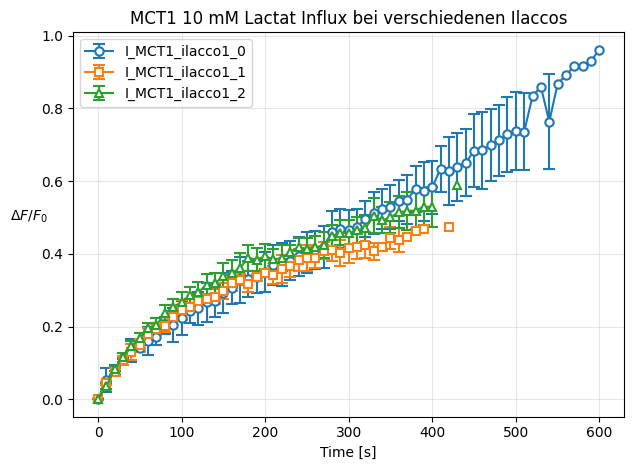

In [15]:
# verschiedene Ilaccos bei 10 mM Lactat Influx
marker = markers.get(conc, 'o')
data_frames = [
    ('I_MCT1_ilacco1_0','o', I_MCT1_ilacco1_0),
    ('I_MCT1_ilacco1_1', 's', I_MCT1_ilacco1_1),
    ('I_MCT1_ilacco1_2', '^', I_MCT1_ilacco1_2)
]

for name,marker, df in data_frames:
    plt.errorbar(df["Time"], df["10 mM Mittelwerte"], yerr=df["10 mM Standardabweichung"], 
                    marker=marker, linestyle='-', label=name, capsize=4, 
                    markerfacecolor='white', markeredgewidth=1.5, markersize=6)
plotted_any = True

plt.xlabel('Time [s]')
plt.ylabel(r'$\Delta F/F_0$', rotation=0, labelpad=12)
plt.title("MCT1 10 mM Lactat Influx bei verschiedenen Ilaccos")
ax = plt.gca()
ax.yaxis.set_label_coords(-0.08, 0.5)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

outpath = os.path.join('..', 'figueres', f'{name}_plot.png')
#plt.savefig(outpath, dpi=300, bbox_inches='tight')
print(f'Saved plot: {outpath}')
plt.show()

Saved plot: ../figueres/I_MCT1_ilacco1_2_plot.png


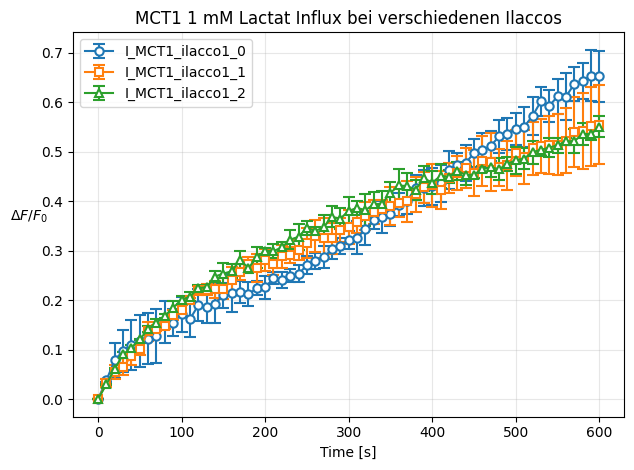

In [16]:
# verschiedene Ilaccos bei 1 mM Lactat Influx
marker = markers.get(conc, 'o')

data_frames = [
    ('I_MCT1_ilacco1_0','o', I_MCT1_ilacco1_0),
    ('I_MCT1_ilacco1_1', 's', I_MCT1_ilacco1_1),
    ('I_MCT1_ilacco1_2', '^', I_MCT1_ilacco1_2)
]

for name,marker, df in data_frames:
    plt.errorbar(df["Time"], df["1 mM Mittelwerte"], yerr=df["1 mM Standardabweichung"], 
                    marker=marker, linestyle='-', label=name, capsize=4, 
                    markerfacecolor='white', markeredgewidth=1.5, markersize=6)
plotted_any = True

plt.xlabel('Time [s]')
plt.ylabel(r'$\Delta F/F_0$', rotation=0, labelpad=12)
plt.title("MCT1 1 mM Lactat Influx bei verschiedenen Ilaccos")
ax = plt.gca()
ax.yaxis.set_label_coords(-0.08, 0.5)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

outpath = os.path.join('..', 'figueres', f'{name}_plot.png')
#plt.savefig(outpath, dpi=300, bbox_inches='tight')
print(f'Saved plot: {outpath}')
plt.show()

Saved plot: ../figueres/I_MCT1_ilacco1_2_plot.png


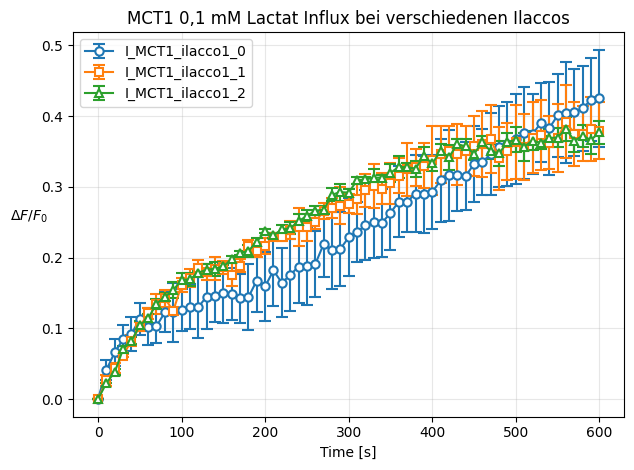

In [17]:
# verschiedene Ilaccos bei 0,1 mM Lactat Influx

marker = ['o',  's', '^']
data_frames = [
    ('I_MCT1_ilacco1_0','o', I_MCT1_ilacco1_0),
    ('I_MCT1_ilacco1_1', 's', I_MCT1_ilacco1_1),
    ('I_MCT1_ilacco1_2', '^', I_MCT1_ilacco1_2)
]

for name,marker, df in data_frames:
    plt.errorbar(df["Time"], df["0,1 mM Mittelwerte"], yerr=df["0,1 mM Standardabweichung"], 
                    marker=marker, linestyle='-', label=name, capsize=4, 
                    markerfacecolor='white', markeredgewidth=1.5, markersize=6)
plotted_any = True

plt.xlabel('Time [s]')
plt.ylabel(r'$\Delta F/F_0$', rotation=0, labelpad=12)
plt.title("MCT1 0,1 mM Lactat Influx bei verschiedenen Ilaccos")
ax = plt.gca()
ax.yaxis.set_label_coords(-0.08, 0.5)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

outpath = os.path.join('..', 'figueres', f'{name}_plot.png')
#plt.savefig(outpath, dpi=300, bbox_inches='tight')
print(f'Saved plot: {outpath}')
plt.show()

Saved combined plot: ../figueres/MCT1_Influx_all_concentrations.png


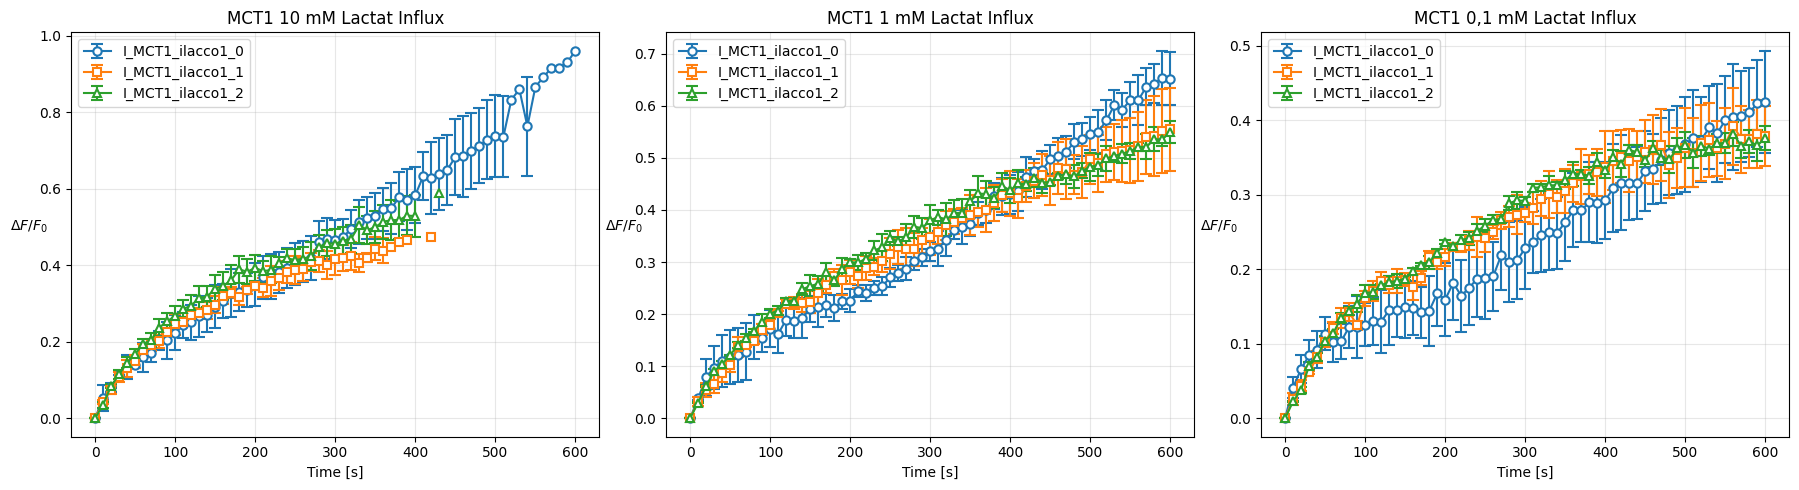

In [18]:
# Kombinierte Abbildung: Verschiedene Ilaccos bei allen drei Konzentrationen
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

data_frames = [
    ('I_MCT1_ilacco1_0', 'o', I_MCT1_ilacco1_0),
    ('I_MCT1_ilacco1_1', 's', I_MCT1_ilacco1_1),
    ('I_MCT1_ilacco1_2', '^', I_MCT1_ilacco1_2)
]

concentrations = [
    ('10 mM', '10 mM Mittelwerte', '10 mM Standardabweichung'),
    ('1 mM', '1 mM Mittelwerte', '1 mM Standardabweichung'),
    ('0,1 mM', '0,1 mM Mittelwerte', '0,1 mM Standardabweichung')
]

for idx, (conc_label, mean_col, std_col) in enumerate(concentrations):
    ax = axes[idx]
    
    for name, marker, df in data_frames:
        ax.errorbar(df["Time"], df[mean_col], yerr=df[std_col], 
                   marker=marker, linestyle='-', label=name, capsize=4, 
                   markerfacecolor='white', markeredgewidth=1.5, markersize=6)
    
    ax.set_xlabel('Time [s]')
    ax.set_ylabel(r'$\Delta F/F_0$', rotation=0, labelpad=12)
    ax.yaxis.set_label_coords(-0.08, 0.5)
    ax.set_title(f"MCT1 {conc_label} Lactat Influx")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
outpath = os.path.join('..', 'figueres', 'MCT1_Influx_all_concentrations.png')
plt.savefig(outpath, dpi=300, bbox_inches='tight')
print(f'Saved combined plot: {outpath}')
plt.show()